In [8]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from matplotlib import pyplot as plt
from PIL import Image

### 1. Traning model

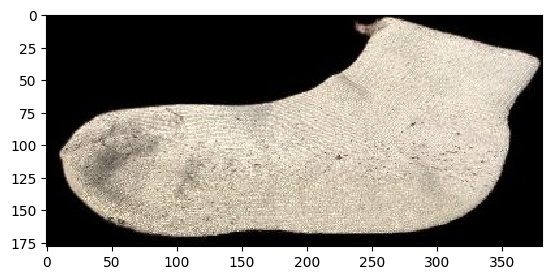

In [16]:
# TODO: Maybe remove rotation later

np_img = np.array(Image.open("../1Data-Collection/Manual/Centered/IMG_0554.jpg")).reshape(1, 178, 381, 3)

datagen = ImageDataGenerator(rotation_range=180)

aug_iter = datagen.flow(np_img, batch_size=1)

fig, ax = plt.subplots(1, 5)
for i in range(5):
  # Show augumented variations
  

